In [1]:
import torch
from diffusers import DDIMScheduler
from torchvision.transforms.functional import to_pil_image

from models.inpaint_image import InpaintPipeline

In [2]:
pipe = InpaintPipeline.from_pretrained(
    'Fantasy-Studio/Paint-by-Example',
    torch_dtype=torch.float16,
    # local_files_only=True
)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
pipe.enable_model_cpu_offload()
pipe.enable_vae_slicing()
pipe.enable_xformers_memory_efficient_attention()

vae\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You are using a model of type clip_vision_model to instantiate a model of type clip. This is not supported for all configurations of models and can yield errors.
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [3]:
import torch, numpy as np
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator
from PIL import Image

model_type = "vit_t"
sam_checkpoint = "./models/weights/mobile_sam.pt"
folder_dir = "data/selfies_dataset/"

device = "cuda" if torch.cuda.is_available() else "cpu"

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)
mobile_sam.eval()

Sam(
  (image_encoder): TinyViT(
    (patch_embed): PatchEmbed(
      (seq): Sequential(
        (0): Conv2d_BN(
          (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Conv2d_BN(
          (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layers): ModuleList(
      (0): ConvLayer(
        (blocks): ModuleList(
          (0-1): 2 x MBConv(
            (conv1): Conv2d_BN(
              (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): Conv2d_BN(
 

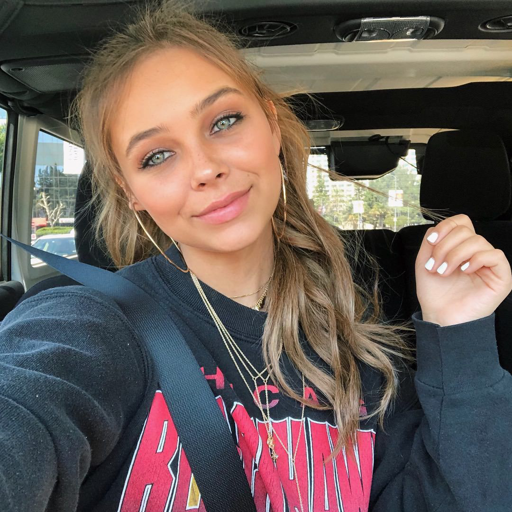

In [4]:
Image.open('data/selfies_dataset/851c9517bbef8cf2509acaef3d0fd099.jpg').resize((512, 512))

In [5]:
mask_generator = SamAutomaticMaskGenerator(mobile_sam)
init_image = Image.open('data/selfies_dataset/851c9517bbef8cf2509acaef3d0fd099.jpg').resize((512, 512))
example_image = Image.open('data/selfies_dataset/1663137622_10-mykaleidoscope-ru-p-veselie-lyudi-pinterest-10.jpg').resize((512, 512))

In [6]:
# init_image = np.asarray(init_image)
# print(init_image.shape)
# masks = mask_generator.generate(init_image)

In [7]:
# needed_masks_ids = [i for i, x in enumerate(masks) if x['area'] / 512 / 512 > 0.5]

In [8]:
# mask = Image.fromarray(~masks[needed_masks_ids[0]]['segmentation']).resize((512, 512))

In [9]:
# mask

In [10]:
# image, _ = generate(Image.fromarray(init_image), example_image, mask_image=mask)
# image

In [11]:
# import os
# from diffusers.utils import make_image_grid
# import random
#
# folder_dir = "data/selfies_dataset/"
# files = os.listdir(folder_dir)
# images_generator = (image for image in random.sample(files, len(files)) if image.endswith(".jpg"))
# images_iterator = iter(images_generator)
#
# couple = []
# generated_images = []
# for path in images_iterator:
#     image = Image.open(folder_dir + path).resize((512, 512))
#     if len(couple) > 0 and len(couple) % 2 == 0:
#         masks = mask_generator.generate(np.asarray(couple[0]))
#         masks.sort(key=lambda x: x['area'], reverse=True)
#         mask = Image.fromarray(~masks[0]['segmentation'])
#         generated_images.append(make_image_grid([
#             *generate(*couple, mask), *couple
#         ], 1, 4))
#         couple.clear()
#     else:
#         couple.append(image)

In [12]:
# for i, image in enumerate(generated_images):
#     image.save(f'./cache/image{i}.png')

In [13]:
# init_image = Image.fromarray(init_image)

In [14]:
from torch import nn
import os
from diffusers.utils import make_image_grid
import random


folder_dir = "data/selfies_dataset/"
files = os.listdir(folder_dir)
images_generator = (image for image in random.sample(files, len(files)) if image.endswith(".jpg"))
images_iterator = iter(images_generator)
couple = []
generated_images = []
for _ in range(2):
    for path in images_iterator:
        image = Image.open(folder_dir + path).resize((512, 512))
        couple.append(image)
        if len(couple) > 0 and len(couple) % 2 == 0:
            source_embeds = pipe.encode_image(couple[0])
            target_embeds = pipe.encode_image(couple[1])
            mask_image = pipe.generate_mask(couple[0],
                                  height=couple[0].height,
                                  width=couple[0].width,
                                  target_prompt_embeds=target_embeds,
                                  source_prompt_embeds=source_embeds,
                                  num_maps_per_mask=10,
                                  mask_encode_strength=0.5,
                                  mask_thresholding_ratio=3.0,
                                  num_inference_steps=50,
                                  guidance_scale=1)
            del source_embeds, target_embeds
            torch.cuda.empty_cache()
            masks = mask_generator.generate(np.asarray(couple[0]))
            cos = nn.CosineSimilarity(dim=1, eps=1e-6)
            masks = [mask for mask in masks if 0.05 > cos(torch.tensor(np.asarray(mask['segmentation'])),
                                                          mask_image).mean()]
            masks.sort(key=lambda x: x['area'], reverse=True)
            mask = Image.fromarray(masks[0]['segmentation'])
            generated_images.append(make_image_grid([
                pipe(image=couple[0],
                     mask_image=mask,
                     example_image=couple[1],
                     num_inference_steps=100).images[0],
                mask, to_pil_image(mask_image, mode='L'), *couple
            ], 1, 5))
            del masks
            torch.cuda.empty_cache()
            couple.clear()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.12 GiB (GPU 0; 6.00 GiB total capacity; 2.69 GiB already allocated; 1.22 GiB free; 2.73 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [15]:
i = 1

In [16]:
for i, image in zip(range(i, i + len(generated_images)), generated_images):
    image.save(f'./cache/image_{i}.png')
i += len(generated_images)